In [3]:
%matplotlib inline
import mhkit
import gridstatus
import numpy as np
import pandas as pd
import requests
import io
import matplotlib.pyplot as plt
import PySAM.Pvwattsv8 as pv

In [4]:
# NDBC data
ndbc_data_file = 'NDBC-46022-2021-spectrum.txt'
# downloaded from https://www.ndbc.noaa.gov/download_data.php?filename=46022w2021.txt.gz&dir=data/historical/swden/
[wave_data,meta] = mhkit.wave.io.ndbc.read_file(ndbc_data_file)
depth = 419 # m
J = mhkit.wave.resource.energy_flux(wave_data.T,depth) # energy flux, W/m
CW = 10 # capture width of WEC, m
P = J * CW # power of WEC, W

In [5]:
# SAM wave 3-hourly data
url = 'https://raw.githubusercontent.com/NREL/SAM/develop/deploy/wave_resource_ts/lat40.84_lon-124.25__2010.csv'
download = requests.get(url).content
file = io.StringIO(download.decode('utf-8'))
parser = lambda y,m,d,H,M: pd.datetime.strptime(f"{y}.{m}.{d}.{H}.{M}", "%Y.%m.%d.%H.%M")

wave_data_2 = pd.read_csv(file, skiprows = 2, parse_dates={"Time":[0,1,2,3,4]}, date_parser=parser)
wave_data_2 = wave_data_2[['Time','Significant Wave Height','Energy Period']]
wave_data_2.head()

,Time,Significant Wave Height,Energy Period
0,2010-01-01 00:00:00,3.21103,9.0149
1,2010-01-01 03:00:00,3.13325,9.2803
2,2010-01-01 06:00:00,3.32286,8.8879
3,2010-01-01 09:00:00,3.35948,8.8694
4,2010-01-01 12:00:00,3.33115,9.3399


In [6]:
# Wave energy time series calculation
rho = 1025
g = 9.8
coeff = rho*(g**2)/(64*np.pi)
wave_data_2["J"] = coeff*wave_data_2["Significant Wave Height"]**2*wave_data_2["Energy Period"]

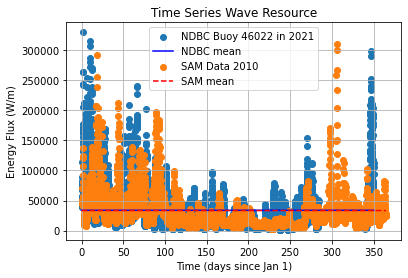

In [7]:
# plot NDBC data alongside SAM data
fig, ax = plt.subplots()
start_date_1 = pd.Timestamp('2021-01-01')

delta_time_1 = (J.index-start_date_1).astype('timedelta64[h]')
ax.scatter(delta_time_1/24, J.J, label='NDBC Buoy 46022 in 2021')
ax.plot(delta_time_1/24, np.full(np.shape(J.index),J.mean(axis=0)), c='blue', label='NDBC mean')

#plt.xlim([J.index[0], J.index[24]])
start_date_2 = pd.Timestamp('2010-01-01')
delta_time_2 = (wave_data_2["Time"]-start_date_2).astype('timedelta64[h]')
ax.scatter(delta_time_2/24, wave_data_2["J"], label='SAM Data 2010')
ax.plot(delta_time_2/24, np.full(np.shape(wave_data_2["J"]),wave_data_2["J"].mean(axis=0)), '--', c='red', label='SAM mean')

ax.legend()
ax.set(xlabel='Time (days since Jan 1)', ylabel='Energy Flux (W/m)', title='Time Series Wave Resource')
ax.grid()

In [8]:
# CAISO data
caiso = gridstatus.CAISO()
start = pd.Timestamp("Jan 1, 2021").normalize()
end = pd.Timestamp("Dec 31, 2021").normalize()
#lmp = caiso.get_lmp(start=start, end=end, market='REAL_TIME_HOURLY', 
#                    locations=["EUREKAA_6_N001"])
lmp = pd.read_csv('lmp-eureka-2021.csv',index_col=0)
lmp["Time"] = pd.to_datetime(lmp["Time"],utc=True).dt.tz_convert('US/Pacific')


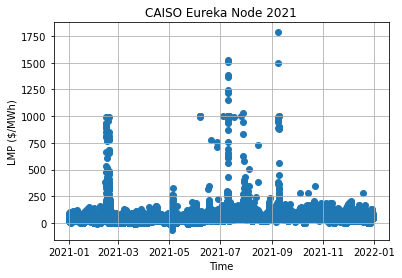

In [9]:
# plot CAISO data
fig, ax = plt.subplots()
ax.scatter(lmp["Time"], lmp["LMP"])
ax.set(xlabel='Time', ylabel='LMP ($/MWh)', title='CAISO Eureka Node 2021')
ax.grid()

In [10]:
# solar data
system_model = pv.default("PVWattsNone")
#system_model.SolarResource.solar_resource_file = filename
#system_model.execute()
#print(system_model.value('annual_energy_distribution_time'))

In [11]:
# value of each energy source
resources = ['wave','wind','solar']
#energies = np.ones(np.shape(J.index)[0] np.size(resources))
#revenue = np.matmul(energies, lmp["LMP"])